In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import inspect

import json
sys.path.append("../scripts/")

In [598]:
from tqdm import tqdm
from collections import defaultdict, Counter
import numpy as np

from datasets import load_metric

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
import seaborn as sns
sns.set()

In [424]:
import config
from analysis_utils import( 
    GenerationStandardData, 
    strip_context_from_generation, 
    get_citations, 
    ParagraphGeneration,
)

In [6]:
PARAGRAPH_GEN_DATA = "/home/bxm200000/models/led_paragraph_generation_v3/"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(PARAGRAPH_GEN_DATA, "checkpoint-29000/"))
special_tokens = ['<doc>','</doc>', '[BOS]', '[Dominant]', '[Reference]', '[B_Dominant]',  '[E_Dominant]', '[B_Reference]', '[E_Reference]', '<context>', '</context>']
additional_special_tokens = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(additional_special_tokens)

0

In [8]:
with open(os.path.join(PARAGRAPH_GEN_DATA, "sample_output_train_paragraph_gen_v3.2.json"), 'r') as f:
    accumulated_data = json.loads(f.read())

In [9]:
def strip_context(paragraph):
    """strip context from paragraph and only return span"""
    return paragraph.split("<context>")[1].split("</context>")[0].strip()

In [10]:
def get_citations(src):
    """Get citations given source content"""
    all_citations = []
    for cite_data in src.split("[B_Reference]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())

    for cite_data in src.split("[B_Dominant]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
    
    return all_citations

In [11]:
predicted, references = [], []
dominant_predicted, dominant_reference = [], []
reference_predicted, reference_reference = [], []
bad_datapoints, good_datapoints = [], []
for index, data in enumerate(accumulated_data):
    target = data["target"]
    gen = data["generated"]
    
    if "<context>" in gen and "</context>" in gen:
        good_datapoints.append(data)
    else:
        bad_datapoints.append(data)



#### 1. PARAGRAPH LENGTH FOR GOOD VS BAD GENERATIONS (AND GROUND TRUTH)

In [30]:
# # PARAGRAPH LENGTH FOR GOOD VS BAD GENERATIONS (AND GROUND TRUTH)

# _, ax = plt.subplots(ncols=2)
# ax[0].hist(
#     [tokenizer.tokenize(x["target"]).__len__() for x in good_datapoints], 
#     bins=50)
# ax[0].hist(
#     [tokenizer.tokenize(x["generated"]).__len__() for x in good_datapoints], 
#     bins=50)
# ax[0].set_title("Good datapoints")
# ax[0].legend(["target", "generated"])


# ax[1].hist([tokenizer.tokenize(x["target"]).__len__()  for x in bad_datapoints], 
#          bins=50)
# ax[1].hist([tokenizer.tokenize(x["generated"]).__len__()  for x in bad_datapoints], 
#          bins=50)
# ax[1].set_title("Bad datapoints")
# ax[1].legend(["target", "generated"])
# plt.suptitle("Paragraph Length Distribution for generated")

In [19]:
# with open(os.path.join(PARAGRAPH_GEN_DATA, "sample_output_train_paragraph_gen_strip_v3.2.json"), 'r') as f:
#     clean_accumulated_data = json.loads(f.read())

#### 2. PARAGRAPH LENGTH DIFFERENCE FOR GOOD VS BAD

In [36]:
# _, ax = plt.subplots(ncols=2)
# ax[0].hist(
#     [tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(x["generated"]).__len__() for x in good_datapoints], 
#     bins=50
# )
# ax[0].set_title("Good datapoints")


# ax[1].hist(
#     [tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(x["generated"]).__len__()  for x in bad_datapoints], 
#      bins=50
# )
# ax[1].set_title("Bad datapoints")
# plt.suptitle("Paragraph Length difference(Target - generation) Distribution")

In [32]:
# par_diffs = ([tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(x["generated"]).__len__()
#      for x in bad_datapoints])

#### 3. SPAN LENGTH FOR GOOD VS BAD FOR GROUND TRUTH

In [58]:
# _, ax = plt.subplots(ncols=3)
# ax[0].hist(
#     [tokenizer.tokenize(strip_context(x["target"])).__len__() for x in good_datapoints], 
#     bins=50
# )
# ax[0].set_title("Good datapoints")


# ax[1].hist([tokenizer.tokenize(strip_context(x["target"])).__len__()  for x in bad_datapoints], 
#          bins=50
# )
# ax[1].set_title("Bad datapoints")


# ax[2].hist(
#     [tokenizer.tokenize(strip_context(x["target"])).__len__() for x in good_datapoints], 
#     bins=50,
#     density=True,
#     alpha = .5
# )
# ax[2].hist([tokenizer.tokenize(strip_context(x["target"])).__len__()  for x in bad_datapoints], 
#          bins=50,
#          density=True,
#          alpha = .5
# )
# ax[2].set_title("Combinbed")
# ax[2].legend(["good", "bad"])
# plt.suptitle(
#     "Span Length Distribution for Ground Truth"
# )

#### 4. CONTEXT LENGTH FOR GOOD VS BAD FOR GROUND TRUTH

In [57]:
# _, ax = plt.subplots(ncols=3)
# ax[0].hist(
#     [tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(strip_context(x["target"])).__len__() for x in good_datapoints], 
#     bins=50
# )
# ax[0].set_title("Good datapoints")


# ax[1].hist([tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(strip_context(x["target"])).__len__()  for x in bad_datapoints], 
#          bins=50
# )
# ax[1].set_title("Bad datapoints")


# ax[2].hist(
#     [tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(strip_context(x["target"])).__len__() for x in good_datapoints], 
#     bins=50,
#     density = True,
#     alpha = .6
# )

# ax[2].hist([tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(strip_context(x["target"])).__len__()  for x in bad_datapoints], 
#          bins=50,
#          density = True,
#          alpha = .6
# )
# ax[2].set_title("Combinbed")
# ax[2].legend(["good", "bad"])

# plt.suptitle(
#     "Context Length Distribution for Ground Truth"
# )

### Compare Paragraph generation with Span generation

### span generation data

In [316]:
span_path = config.SPAN_GEN_MODEL_PATH

In [317]:
with open(os.path.join(span_path, "sample_output.json"), 'r') as f:
    span_accumulated_data = json.loads(f.read())

In [318]:
span_diff = [tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(x["generated"]).__len__()
     for x in span_accumulated_data]

In [319]:
par_diffs = ([tokenizer.tokenize(strip_context(x["target"])).__len__() - tokenizer.tokenize(strip_context(x["generated"])).__len__()
     for x in good_datapoints])

In [320]:
par_diffs_paragraph = ([tokenizer.tokenize(x["target"]).__len__() - tokenizer.tokenize(x["generated"]).__len__()
     for x in good_datapoints])

In [322]:
# _, ax = plt.subplots(ncols=2)
# ax[0].hist(
#     par_diffs,
#     bins=100, range=(-100,100))
# ax[0].set_title("pargraph generation.  Median ~ {}, Mean ~{}".format(np.median(par_diffs), np.mean(par_diffs)))


# ax[1].hist(
#         span_diff,
#          bins=100, range=(-100,100))
# ax[1].set_title("span generation. Median ~ {}, Mean ~{}".format(np.median(span_diff), np.mean(span_diff)))
# plt.suptitle("Target span length - Generated span length")

In [337]:
# plt.hist(
#     par_diffs,
#     bins=100, 
#     range=(-100,100),
#     alpha=.6,
#     density=True
# )
# # ax[0].set_title("pargraph generation.  Median ~ {}, Mean ~{}".format(np.median(par_diffs), np.mean(par_diffs)))


# plt.hist(
#         span_diff,
#         bins=100, 
#         range=(-100,100),
#         alpha=.6,
#         density=True
# )
# plt.legend(["paragraph", "span"])
# # ax[1].set_title("span generation. Median ~ {}, Mean ~{}".format(np.median(span_diff), np.mean(span_diff)))
# # plt.suptitle("Target span length - Generated span length")

Text(0.5, 1.0, 'Target Paragraph length - Generated paragraph. length  Median ~ 0.0, Mean ~3.47')

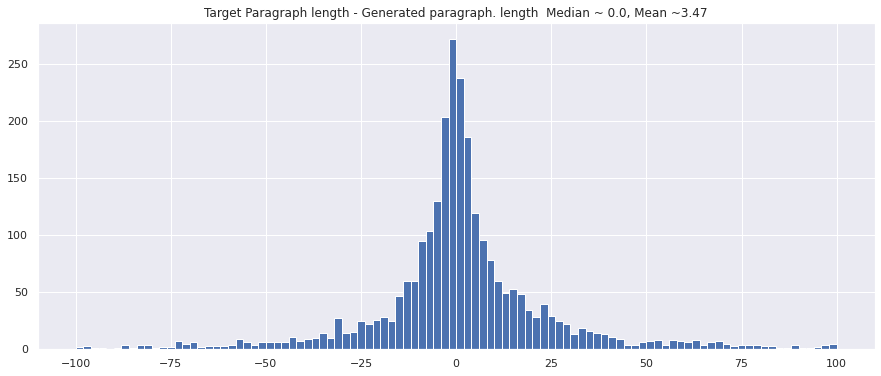

In [336]:
plt.hist(
    par_diffs_paragraph,
    bins=100, range=(-100,100)
)
plt.title(
    "Target Paragraph length - Generated paragraph. length  Median ~ {}, Mean ~{}".format(
        np.median(par_diffs_paragraph), np.round(np.mean(par_diffs_paragraph), decimals=2)
    )
)

In [333]:
sum(par_diffs_paragraph) / len(par_diffs_paragraph)

3.467923160565422

In [74]:
c = 0
for diff, data in zip(par_diffs, good_datapoints):
    if diff < -50:
        print(diff)
        print(data["part_id"])
        print(tokenizer.tokenize(data["target"]).__len__())
        print(tokenizer.tokenize(data["generated"]).__len__())
        print("Citation count", data["source"].count("[E_Dominant]") + data["source"].count("[E_Reference]"))
        print("\n\n")
        c += 1

-74
118680003_0_0_6
458
417
Citation count 1



-118
102350797_0_0_4
458
566
Citation count 1



-129
102350797_1_0_2
499
603
Citation count 1



-127
126181046_1_0_2
182
310
Citation count 2



-77
126181046_3_0_0
147
229
Citation count 1



-114
102350939_1_0_3
196
299
Citation count 1



-82
102350939_2_0_1
410
271
Citation count 1



-119
102350939_3_0_4
188
309
Citation count 1



-60
173990530_1_0_0
213
276
Citation count 1



-175
160009452_3_0_0
87
259
Citation count 2



-57
173991071_2_0_5
333
414
Citation count 1



-51
174798390_1_0_0
51
104
Citation count 1



-67
162183964_3_0_0
81
154
Citation count 1



-56
166228313_0_0_4
192
250
Citation count 1



-100
166228313_2_0_0
188
288
Citation count 4



-69
174797942_2_0_1
123
192
Citation count 2



-52
199379304_2_0_0
127
181
Citation count 1



-89
75134948_1_0_1
216
303
Citation count 1



-62
91184245_2_0_1
267
329
Citation count 2



-94
198184826_1_0_1
148
243
Citation count 1



-77
198974416_0_0_1
257
337
Citation c

(array([ 8., 20., 39., 21.,  9.,  7.,  7.,  6.,  5.,  4.]),
 array([ 51. , 109.3, 167.6, 225.9, 284.2, 342.5, 400.8, 459.1, 517.4,
        575.7, 634. ]),
 <BarContainer object of 10 artists>)

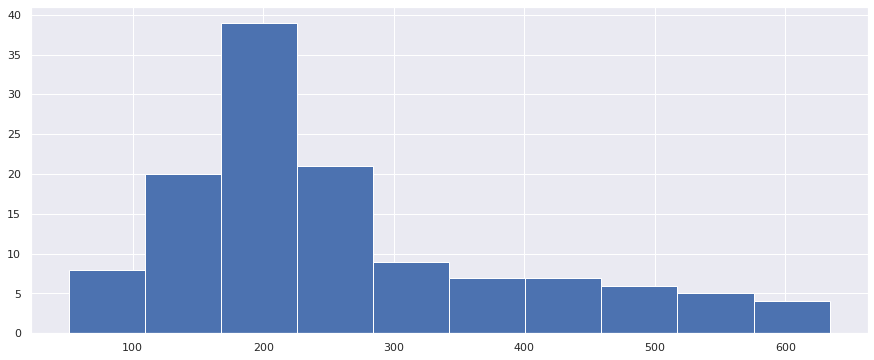

In [68]:
# Length of target where generations is too large
plt.hist(
    [tokenizer.tokenize(data["target"]).__len__() for diff, data in zip(par_diffs, good_datapoints) if diff < -50], 
#     range=(0,3000)
)

In [225]:
# good_datapoints

In [338]:
# plt.hist([tokenizer.tokenize(x["target"]).__len__() for x in good_datapoints], bins=100,
# #          range=(0,3000)
#         )

In [71]:
# # Length of Generation and Target for Paragraph generation data

# _, ax = plt.subplots(ncols=2)

# ax[0].hist(
#     [tokenizer.tokenize(strip_context(x["generated"])).__len__() for x in good_datapoints],
#     bins=50,
# #     range=(0,200)
# )
# ax[0].set_title("Generated Length")
# ax[1].hist(
#     [tokenizer.tokenize(strip_context(x["target"])).__len__() for x in good_datapoints],
#     bins=50,
# #     range=(0,200)
# )
# ax[1].set_title("Target Length")

In [80]:
rouge = load_metric("rouge")

In [465]:
para_accumulated_data = strip_context_from_generation(accumulated_data)

In [467]:
# para_accumulated_data[0]

### Analyze different Rouge scores
Analyze rouge scores of pargraph generation and span generation. compare them

In [299]:
def remove_citation_from_sentence(sentence, source):
    """remove citation marks from sentence"""
    sentence = sentence.replace(",", "").replace(".", "")
    for c in get_citations(source):
        c = c.replace(",", "").replace(".", "")
        sentence = sentence.replace(c, "")
    return sentence

In [527]:
# para_accumulated_data[0]

In [676]:
# MAP SPAN and PARAGRAPH GENERATION USING "part_id"S

count = 0

citation_count_par_gen, citation_count_span_gen, citation_count = 0, 0, 0
for data in tqdm(para_accumulated_data):
    for span_data in span_accumulated_data:
        if span_data["part_id"] == data["part_id"]:
            data["span_generated"] = span_data["generated"]
            data["par_generated"] = data["generated"]
            
            assert data["target"] == span_data["target"], """{}\n\n{}""".format(
                data["target"], span_data["target"]
            )
            
            
#             GET SPAN GENERATION ROUGE SCORE
            gen = span_data["generated"]
            target = span_data["target"]
            
            
            #before removing citation marks
#             data["span_raw_rouge"] = rouge.compute(
#                 predictions=[gen],
#                 references=[target],
#                 rouge_types=["rouge1"]
#             )["rouge1"].mid.recall
            
            for c in get_citations(span_data["source"]):
                citation_count += 1
                if c.replace(",", "").replace(".", "") in gen.replace(",", "").replace(".", ""):
                    citation_count_span_gen += 1
            
#             gen = remove_citation_from_sentence(gen, span_data["source"])
#             target = remove_citation_from_sentence(target, span_data["source"])    
    
            
#             # after removing citation marks
#             data["span_rouge"] = rouge.compute(
#                 predictions=[gen],
#                 references=[target],
#                 rouge_types=["rouge1"]
#             )["rouge1"].mid.recall
            
            
            # GET PARAGRAPH GENERATION ROUGE SCORE
            gen = data["generated"]
            target = data["target"]
            
            for c in get_citations(data["source"]):
                if c.replace(",", "").replace(".", "") in gen.replace(",", "").replace(".", ""):
                    citation_count_par_gen += 1
#                 else:
#                     print(gen)
#                     print(target)
#                     print("\n")
            
            # before removing citation marks
#             data["para_raw_rouge"] = rouge.compute(
#                 predictions=[gen],
#                 references=[target],
#                 rouge_types=["rouge1"]
#             )["rouge1"].mid.recall
            
#             gen = remove_citation_from_sentence(gen, data["source"])
#             target = remove_citation_from_sentence(target, data["source"])    
    
#             # after removing citation marks
#             data["para_rouge"] = rouge.compute(
#                 predictions=[gen],
#                 references=[target],
#                 rouge_types=["rouge1"]
#             )["rouge1"].mid.recall

            
    
              # COMPARE SPAN AND PARAGRAPH GENERATION
            
        
#             gen = data["generated"]
#             target = span_data["generated"]
#             for c in get_citations(span_data["source"]):
#                 if c.replace(",", "").replace(".", "") in gen.replace(",", "").replace(".", ""):
#                     citation_count_span_gen += 1
            
#             gen = remove_citation_from_sentence(gen, data["source"])
#             target = remove_citation_from_sentence(target, span_data["source"])    
    
            
        
        
#             rr = rouge.compute(
#                 predictions=[gen],
#                 references=[target],
#                 rouge_types=["rouge1"]
#             )

#             rouge_score = rr["rouge1"].mid.precision
#             data["rouge1_span_gen_par_gen"] = rouge_score
            
            count += 1
            # break as already found a part_id match
            break

100%|██████████| 2759/2759 [00:00<00:00, 3669.75it/s]


In [168]:
# for data in para_accumulated_data:
#     if data["rouge1_span_gen_par_gen"] < .4:
#         print("part id: {}\nspan generation\n{}\npara generation\n{}".format(
#             data["part_id"], data["span_generated"], data["par_generated"] )
#         )
#         print("")
#         print(data["target"])
#         print("\n\n")

In [653]:
sorted_para_accumulated_data = sorted(
    para_accumulated_data, 
    key = lambda x : x["para_rouge"] - x["span_rouge"] , 
    reverse=True
)

In [606]:
bad_par_gen_citation_types, good_par_gen_citation_types = [], []
for data in sorted_para_accumulated_data:
    par_length = tokenizer.tokenize(
        data["par_generated"]
    ).__len__()
    span_length = tokenizer.tokenize(
        data["span_generated"]
    ).__len__()
    
    rouge_diff = data["para_rouge"] - data["span_rouge"]


    
    data = GenerationStandardData(data)
    
    if rouge_diff < - 0.1:
        bad_par_gen_citation_types.append(data.citation_type)
    elif rouge_diff > .1:
        good_par_gen_citation_types.append(data.citation_type)



In [615]:
Counter(good_par_gen_citation_types), Counter(bad_par_gen_citation_types)

(Counter({'Dominant': 385, 'Reference': 358}),
 Counter({'Reference': 279, 'Dominant': 174}))

In [669]:
# # analyze scores#
# # i = -1
# i +=1

# par_length = tokenizer.tokenize(sorted_para_accumulated_data[i]["par_generated"]).__len__()
# span_length = tokenizer.tokenize(sorted_para_accumulated_data[i]["span_generated"]).__len__()

# while "[Dominant]" not in sorted_para_accumulated_data[i]["source"] or abs(par_length - span_length) > 50:
#     i += 1
#     par_length = tokenizer.tokenize(sorted_para_accumulated_data[i]["par_generated"]).__len__()
#     span_length = tokenizer.tokenize(sorted_para_accumulated_data[i]["span_generated"]).__len__()

# sorted_para_accumulated_data[i]

In [670]:
# plt.hist(
#     [x["para_rouge"] - x["span_rouge"] for x in sorted_para_accumulated_data], 
#     bins=50
# ) 
# plt.title("paragraph rouge1 recall - span rouge1 recall")

In [671]:
rouge_diff_ref = []

for x in sorted_para_accumulated_data:
    if "[Reference]" in x["source"]:
        rouge_diff_ref.append(x["para_rouge"] - x["span_rouge"])

In [674]:
# sum(rouge_diff_ref)

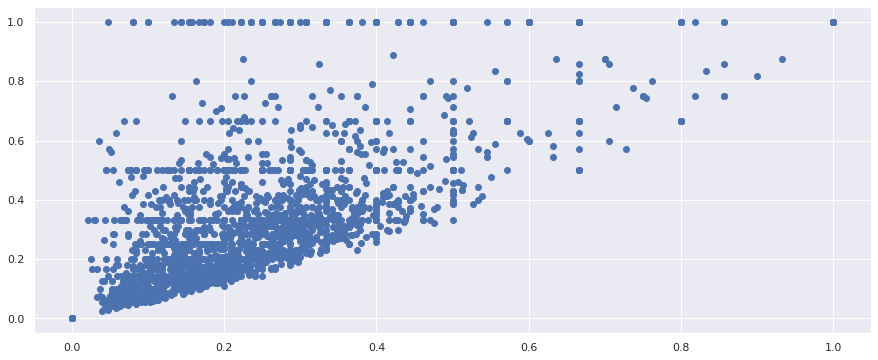

In [259]:
plt.scatter(
    [x["rouge1_span_gen_par_gen"] for x in sorted_para_accumulated_data],
    [x["para_rouge"] for x in sorted_para_accumulated_data],
)

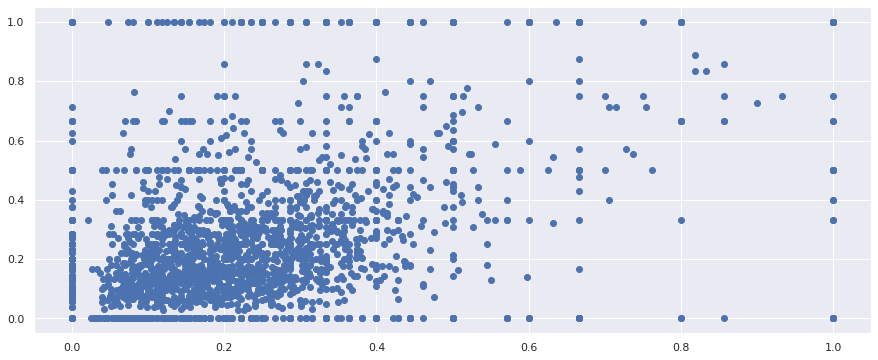

In [260]:
plt.scatter(
    [x["rouge1_span_gen_par_gen"] for x in sorted_para_accumulated_data],
    [x["span_rouge"] for x in sorted_para_accumulated_data],
)

Text(0, 0.5, 'Span generation rouge recall score')

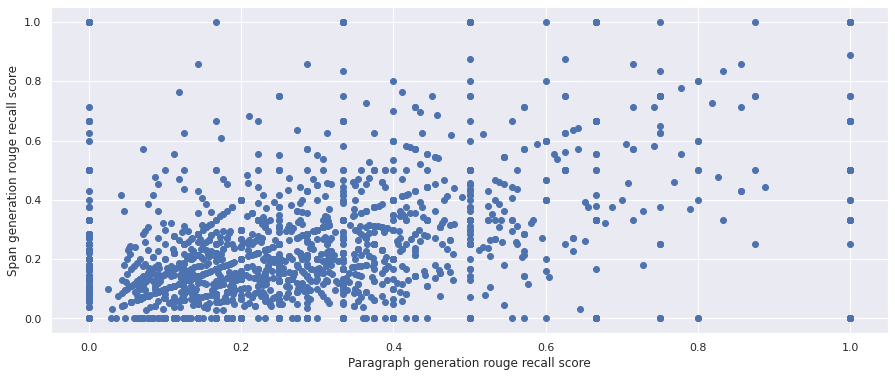

In [261]:
plt.scatter(
    [x["para_rouge"] for x in sorted_para_accumulated_data],
    [x["span_rouge"] for x in sorted_para_accumulated_data],
)
plt.xlabel("Paragraph generation rouge recall score")
plt.ylabel("Span generation rouge recall score")

In [342]:
# plt.hist(
#     [x["rouge1_span_gen_par_gen"] for x in sorted_para_accumulated_data],
#     bins=10
# )

In [343]:
# #precision
# plt.hist(
#     [x["rouge1_span_gen_par_gen"] for x in sorted_para_accumulated_data],
#     bins=10
# )

In [341]:
# #recall
# plt.hist(
#     [x["rouge1_span_gen_par_gen"] for x in sorted_para_accumulated_data],
#     bins=10
# )

### Analyzing Longer generations and haullucinations in generation

In [425]:
from copy import deepcopy

In [426]:
para_generation_data = deepcopy(good_datapoints)

In [471]:
for data in tqdm(para_generation_data):
    
    data_instance = GenerationStandardData(data)
    generated_instance = ParagraphGeneration(
        data["generated"], 
        data["source"]
    )
        
    target_instance = ParagraphGeneration(
        data["target"], 
        data["source"]
    )
    
    # generated span and actual context overlapp
    data["span_context_rouge"] = rouge.compute(
        predictions=[target_instance.context],
        references=[generated_instance.span_text],
        rouge_types=["rougeL"]
    )["rougeL"].mid.recall
    
    
    # generated span and current abstract overlapp
    data["span_current_paper_rouge"] = rouge.compute(
        predictions=[data_instance.current_abstract],
        references=[generated_instance.span_text],
        rouge_types=["rougeL"]
    )["rougeL"].mid.recall
    
    
    # generated context and current abstract overlapp
    data["gen_context_current_abstract_rouge"] = rouge.compute(
        predictions=[data_instance.current_abstract],
        references=[generated_instance.context],
        rouge_types=["rougeL"]
    )["rougeL"].mid.recall
    
    
    

100%|██████████| 2759/2759 [06:52<00:00,  6.69it/s]


In [501]:
# ADDITIONAL ROUGE SCORE OF GENERATION VS CITED PAPERS
for data in tqdm(para_generation_data):
    
    data_instance = GenerationStandardData(data)
    generated_instance = ParagraphGeneration(
        data["generated"], 
        data["source"]
    )
        
    # generated context and current abstract overlapp
    data["gen_cited_paper_rouge"] = rouge.compute(
        predictions=[data_instance.related_work],
        references=[generated_instance.span_text],
        rouge_types=["rougeL"]
    )["rougeL"].mid.recall
    
    
    

100%|██████████| 2759/2759 [01:53<00:00, 24.37it/s]


In [440]:
# para_generation_data[0]

In [483]:
# cut = 0
length_track = []
for x in para_generation_data:
    if x["span_current_paper_rouge"] > .9:
        gen_instance = ParagraphGeneration(
            x["generated"], x["source"]
        )
        target_instance = ParagraphGeneration(
            x["target"], x["source"]
        )
        length_track.append(tokenizer.tokenize(target_instance.span_text).__len__() \
        - tokenizer.tokenize(gen_instance.span_text).__len__())
        

In [489]:
# cut = 0
rouge_track = []
for x in para_generation_data:
    gen_instance = ParagraphGeneration(
        x["generated"], x["source"]
    )
    target_instance = ParagraphGeneration(
        x["target"], x["source"]
    )
    diff = tokenizer.tokenize(target_instance.span_text).__len__() \
        - tokenizer.tokenize(gen_instance.span_text).__len__()
    
    if diff < - 60 :
        rouge_track.append(x["span_context_rouge"])        

In [491]:
# rouge_track

(array([1., 0., 1., 5., 6., 5., 7., 8., 8., 8., 7., 4., 7., 4., 3., 4., 3.,
        3., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0., 2., 1., 1.]),
 array([0.        , 0.0195082 , 0.03901639, 0.05852459, 0.07803279,
        0.09754098, 0.11704918, 0.13655738, 0.15606557, 0.17557377,
        0.19508197, 0.21459016, 0.23409836, 0.25360656, 0.27311475,
        0.29262295, 0.31213115, 0.33163934, 0.35114754, 0.37065574,
        0.39016393, 0.40967213, 0.42918033, 0.44868852, 0.46819672,
        0.48770492, 0.50721311, 0.52672131, 0.54622951, 0.5657377 ,
        0.5852459 , 0.6047541 , 0.6242623 , 0.64377049, 0.66327869,
        0.68278689, 0.70229508, 0.72180328, 0.74131148, 0.76081967,
        0.78032787, 0.79983607, 0.81934426, 0.83885246, 0.85836066,
        0.87786885, 0.89737705, 0.91688525, 0.93639344, 0.95590164,
        0.97540984]),
 <BarContainer object of 50 artists>)

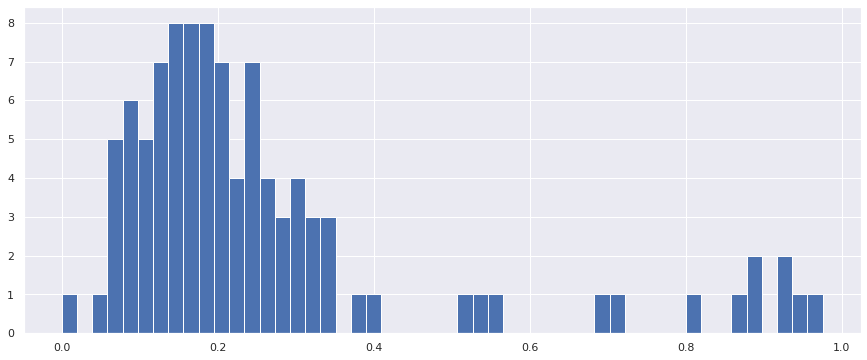

In [492]:
plt.hist(rouge_track, bins=50)

(array([159., 316., 620., 570., 443., 417., 122.,  49.,  37.,  26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

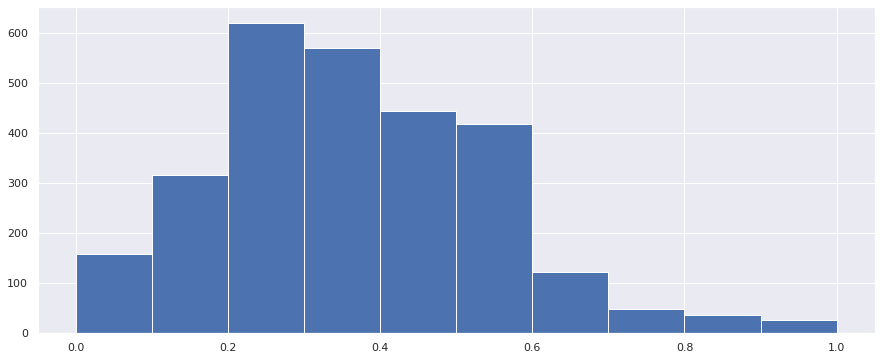

In [510]:
plt.hist([x["gen_cited_paper_rouge"] for x in para_generation_data])

In [511]:
hallucination_candidates = []

for x in para_generation_data:
    if x["gen_cited_paper_rouge"] < .1 and x["span_context_rouge"] < .1 and x["span_current_paper_rouge"] < .3:
        hallucination_candidates.append(deepcopy(x))
        

In [522]:
# i = 3
i += 1
hallucination_candidates[i]

{'source': 'Many methods have been developed to generate paraphrases automatically (Madnani and J. Dorr, 2010) . Approaches relying on Machine Translation (MT) have proven popular due to the scarcity of labeled paraphrase pairs (Callison-Burch, 2007; Mallinson et al., 2017; Iyyer et al., 2018) . Recent progress in MT with neural methods Vaswani et al., 2017) has popularized this latter strategy. Conceptually, translation is appealing since it abstracts semantic content from its linguistic realization. For instance, assigning the same source sentence to multiple translators will result in a rich set of semantically close sentences (Callison-Burch, 2007) . At the same time, bilingualism does not seem necessary to humans to generate paraphrases. This work evaluates if data in two languages is necessary for paraphrasing. We consider three settings: supervised translation (parallel bilingual data is used), unsupervised translation (nonparallel corpora in two languages are used) and monoling

In [516]:
new_length_track = []
for x in hallucination_candidates:
    gen_instance = ParagraphGeneration(
        x["generated"], x["source"]
    )
    target_instance = ParagraphGeneration(
        x["target"], x["source"]
    )
    new_length_track.append(tokenizer.tokenize(target_instance.span_text).__len__() \
    - tokenizer.tokenize(gen_instance.span_text).__len__())

In [520]:
# plt.hist(new_length_track)

### For Span Generation

In [472]:
for data in tqdm(span_accumulated_data):
    
    data_instance = GenerationStandardData(data)

    
    # generated span and current abstract overlapp
    data["span_current_paper_rouge"] = rouge.compute(
        predictions=[data_instance.current_abstract],
        references=[data["generated"]],
        rouge_types=["rougeL"]
    )["rougeL"].mid.recall
    
    
    

100%|██████████| 2983/2983 [02:08<00:00, 23.29it/s]


(array([ 43.,  66., 187., 425., 537., 791., 407., 223., 177., 127.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

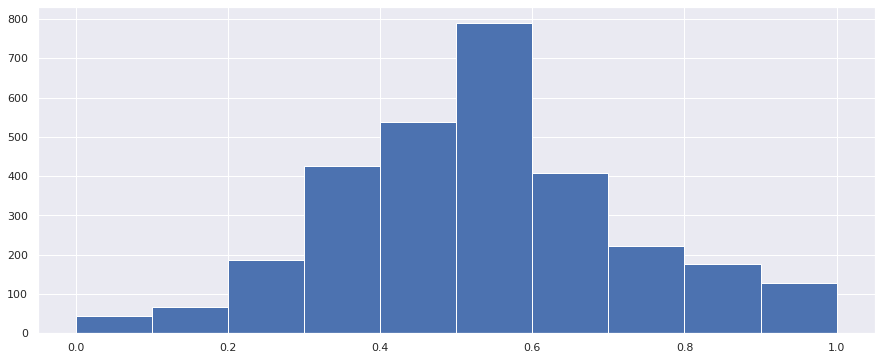

In [485]:
plt.hist([x["span_current_paper_rouge"] for x in span_accumulated_data])